In [ ]:
!gdown --id 1zxBVRqVQXDpHO5_pP_8tTzm6B5adUCtO

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zxBVRqVQXDpHO5_pP_8tTzm6B5adUCtO
To: /content/df_capped.csv
100% 6.12M/6.12M [00:00<00:00, 24.4MB/s]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Load dataset
df_capped_2 = pd.read_csv("/content/df_capped.csv")

In [ ]:
df_capped_2.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


# **Challange 3. Dynamic Pricing**

1.  Feature Engineering
2.  Null values Fillup, Outliers Removal
3.  Scaling the numerical values
4.  Label Encoding Categorical values
5.  Train Test Split
6.  Model Train

*   Linear Regression
*   Decision Tree
*   Random Forest
*   Gradient Boosting
*   XGBoost
*   LightGBM

7.  HyperParameter Tuning
8.  X-AI

*   SHAP
*   LIME

In [ ]:
missing_values = df_capped_2.isna().sum()
missing_values_percent = 100 * df_capped_2.isna().sum()/len(df_capped_2)
print(missing_values_percent)
print(missing_values)

Date                  0.0
Store ID              0.0
Product ID            0.0
Category              0.0
Region                0.0
Inventory Level       0.0
Units Sold            0.0
Units Ordered         0.0
Demand Forecast       0.0
Price                 0.0
Discount              0.0
Weather Condition     0.0
Holiday/Promotion     0.0
Competitor Pricing    0.0
Seasonality           0.0
dtype: float64
Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64


In [ ]:
!pip install shap lime

## 1. Feature Engineering

In [ ]:
# Convert Date column to datetime
df_capped_2["Date"] = pd.to_datetime(df_capped_2["Date"])
df_capped_2["Year"] = df_capped_2["Date"].dt.year
df_capped_2["Month"] = df_capped_2["Date"].dt.month
df_capped_2["Day"] = df_capped_2["Date"].dt.day
df_capped_2["Weekday"] = df_capped_2["Date"].dt.weekday
df_capped_2["Is_Weekend"] = (df_capped_2["Weekday"] >= 5).astype(int)

# df_capped_2.drop(columns=["Date"], inplace=True)

# Feature Engineering
## Demand-based features
df_capped_2["Demand_to_Inventory_Ratio"] = df_capped_2["Units Sold"] / (df_capped_2["Inventory Level"] + 1)
df_capped_2["Demand_Variation"] = df_capped_2["Demand Forecast"] - df_capped_2["Units Sold"]

## Pricing-based features
df_capped_2["Price_Discounted"] = df_capped_2["Price"] * (1 - df_capped_2["Discount"] / 100)
df_capped_2["Price_Diff_Competitor"] = df_capped_2["Price"] - df_capped_2["Competitor Pricing"]
df_capped_2["Historical_Discount_Impact"] = df_capped_2["Discount"] / (df_capped_2["Price"] + 1)

## Seasonality-based features
df_capped_2["Seasonal_Impact"] = df_capped_2["Seasonality"].map({"Winter": 0.8, "Spring": 1.0, "Summer": 1.2, "Autumn": 1.0})
df_capped_2["Holiday_Influence"] = df_capped_2["Holiday/Promotion"] * df_capped_2["Seasonal_Impact"]

df_capped_2["Weather_Impact"] = df_capped_2["Weather Condition"].map({"Sunny": 1.2, "Rainy": 0.9, "Cloudy": 1.0})


In [ ]:
df_capped_2.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,...,Weekday,Is_Weekend,Demand_to_Inventory_Ratio,Demand_Variation,Price_Discounted,Price_Diff_Competitor,Historical_Discount_Impact,Seasonal_Impact,Holiday_Influence,Weather_Impact
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,...,5,1,0.547414,8.47,26.800,3.81,0.579710,1.0,0.0,0.9
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,...,5,1,0.731707,-5.96,50.408,-3.15,0.312451,1.0,0.0,1.2
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,...,5,1,0.631068,9.02,25.191,-3.33,0.344947,1.2,1.2,1.2
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,...,5,1,0.129787,1.18,29.448,-2.02,0.296560,1.0,1.0,1.0
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,...,5,1,0.083832,-4.74,73.640,4.69,0.000000,1.2,0.0,1.2


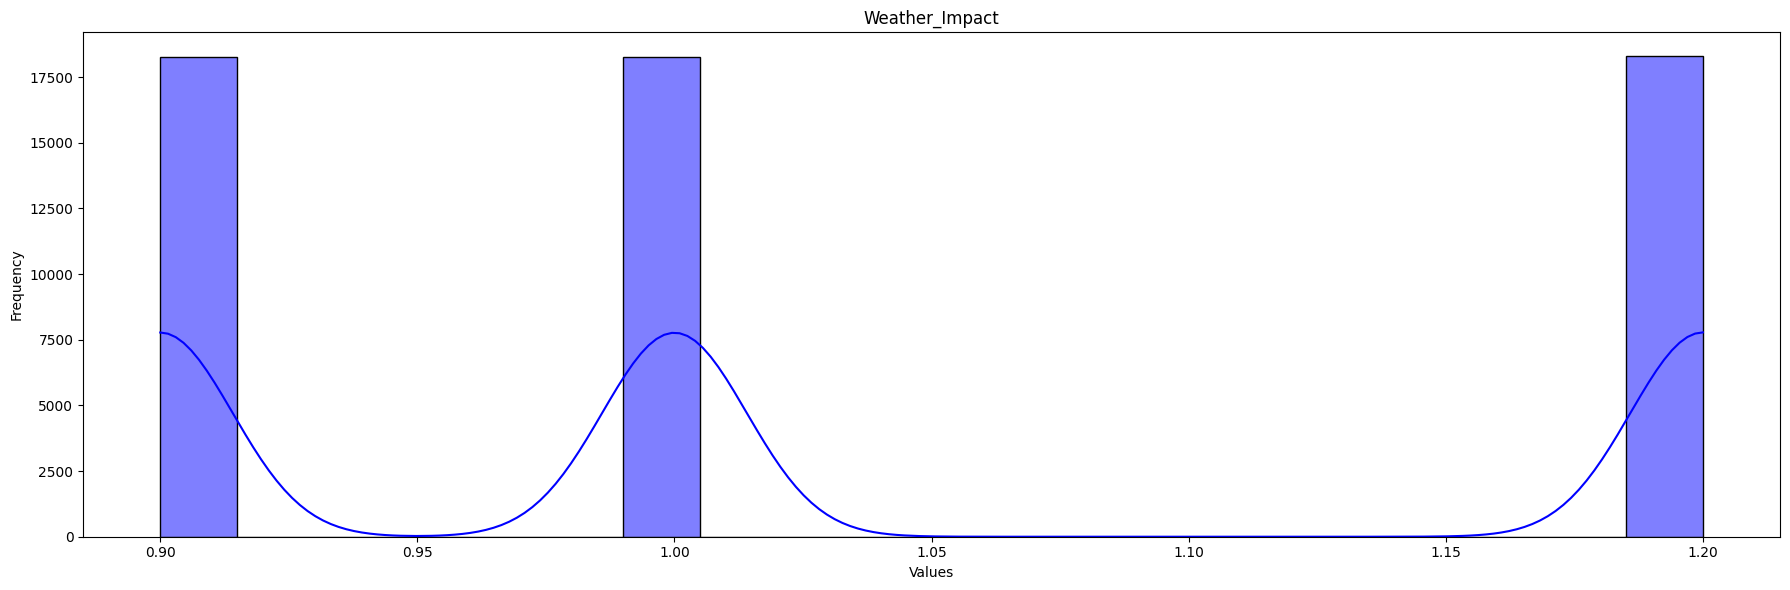

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Prepare data,
Weather_Impact = df_capped_2['Weather_Impact']

#Create the figure
fig, axs = plt.subplots(1,1, figsize=(18, 6), sharey=True)

#Plot WBC COUNT histogram
sns.histplot( Weather_Impact , bins=20, color='blue', edgecolor='black',kde = True, ax=axs)
axs.set_title('Weather_Impact')
axs.set_xlabel('Values')
axs.set_ylabel('Frequency')

#Adjust layout and show the plot
plt.tight_layout()
plt.show()

## 2. Null values Fillup, Outliers Removal


*   Finding Missing Values
*   Filling the missing values
*   Detect Outliers
*   Remove Outliers

In [ ]:
missing_values = df_capped_2.isna().sum()
missing_values_percent = 100 * df_capped_2.isna().sum()/len(df_capped_2)
print(missing_values_percent)
print(missing_values)

Date                           0.000000
Store ID                       0.000000
Product ID                     0.000000
Category                       0.000000
Region                         0.000000
Inventory Level                0.000000
Units Sold                     0.000000
Units Ordered                  0.000000
Demand Forecast                0.000000
Price                          0.000000
Discount                       0.000000
Weather Condition              0.000000
Holiday/Promotion              0.000000
Competitor Pricing             0.000000
Seasonality                    0.000000
Year                           0.000000
Month                          0.000000
Day                            0.000000
Weekday                        0.000000
Is_Weekend                     0.000000
Demand_to_Inventory_Ratio      0.000000
Demand_Variation               0.000000
Price_Discounted               0.000000
Price_Diff_Competitor          0.000000
Historical_Discount_Impact     0.000000


In [ ]:
df_capped_2["Weather_Impact"] = df_capped_2.groupby("Seasonality")["Weather_Impact"].transform(lambda x: x.fillna(x.median()))


In [ ]:
missing_values = df_capped_2.isna().sum()
missing_values_percent = 100 * df_capped_2.isna().sum()/len(df_capped_2)
print(missing_values_percent)
print(missing_values)

Date                          0.0
Store ID                      0.0
Product ID                    0.0
Category                      0.0
Region                        0.0
Inventory Level               0.0
Units Sold                    0.0
Units Ordered                 0.0
Demand Forecast               0.0
Price                         0.0
Discount                      0.0
Weather Condition             0.0
Holiday/Promotion             0.0
Competitor Pricing            0.0
Seasonality                   0.0
Year                          0.0
Month                         0.0
Day                           0.0
Weekday                       0.0
Is_Weekend                    0.0
Demand_to_Inventory_Ratio     0.0
Demand_Variation              0.0
Price_Discounted              0.0
Price_Diff_Competitor         0.0
Historical_Discount_Impact    0.0
Seasonal_Impact               0.0
Holiday_Influence             0.0
Weather_Impact                0.0
dtype: float64
Date                          0
S

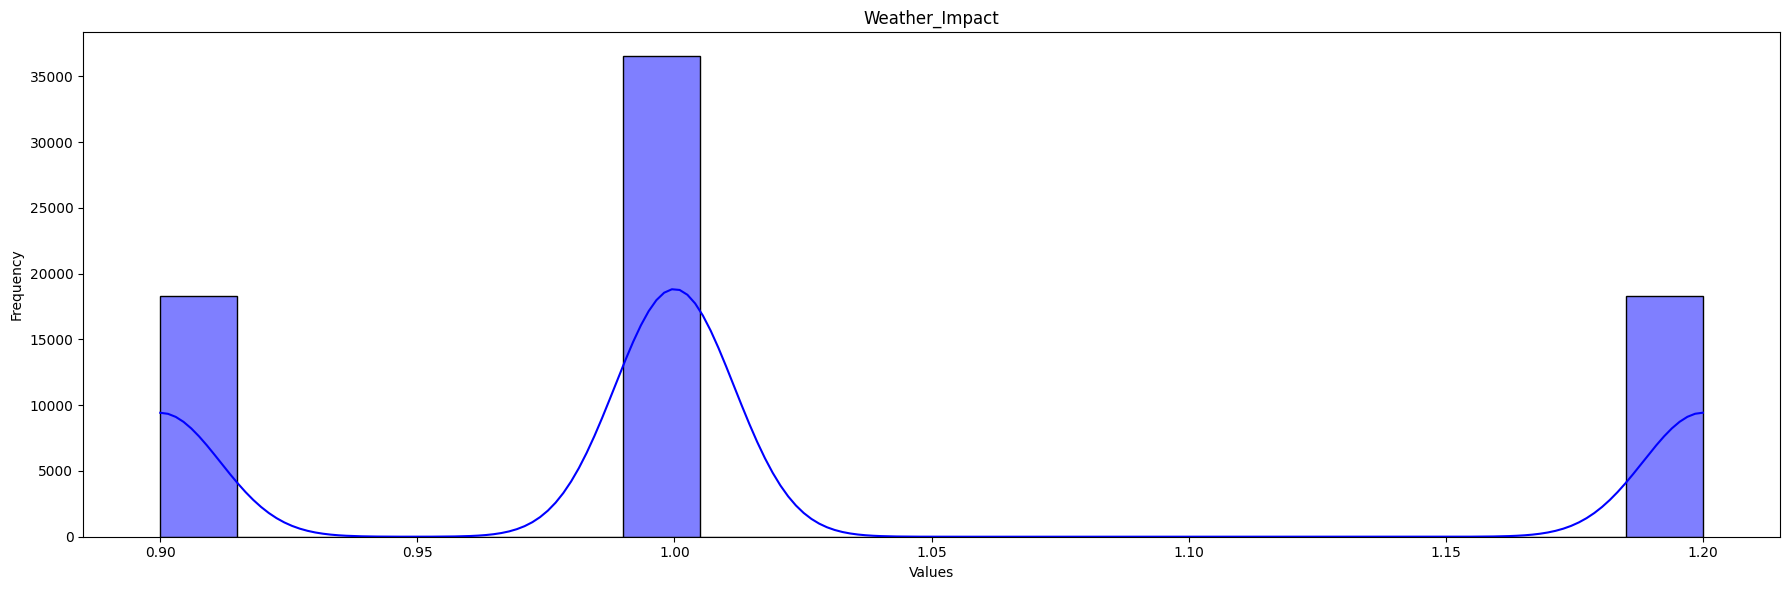

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Prepare data,
Weather_Impact = df_capped_2['Weather_Impact']

#Create the figure
fig, axs = plt.subplots(1,1, figsize=(18, 6), sharey=True)

#Plot WBC COUNT histogram
sns.histplot( Weather_Impact , bins=20, color='blue', edgecolor='black',kde = True, ax=axs)
axs.set_title('Weather_Impact')
axs.set_xlabel('Values')
axs.set_ylabel('Frequency')

#Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Drop non-numeric features for modeling
df_capped = df_capped_2.drop(columns=["Store ID", "Product ID"])
df_capped

,Date,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,...,Weekday,Is_Weekend,Demand_to_Inventory_Ratio,Demand_Variation,Price_Discounted,Price_Diff_Competitor,Historical_Discount_Impact,Seasonal_Impact,Holiday_Influence,Weather_Impact
0,2022-01-01,Groceries,North,231,127,55,135.47,33.50,20,Rainy,...,5,1,0.547414,8.47,26.800,3.81,0.579710,1.0,0.0,0.9
1,2022-01-01,Toys,South,204,150,66,144.04,63.01,20,Sunny,...,5,1,0.731707,-5.96,50.408,-3.15,0.312451,1.0,0.0,1.2
2,2022-01-01,Toys,West,102,65,51,74.02,27.99,10,Sunny,...,5,1,0.631068,9.02,25.191,-3.33,0.344947,1.2,1.2,1.2
3,2022-01-01,Toys,North,469,61,164,62.18,32.72,10,Cloudy,...,5,1,0.129787,1.18,29.448,-2.02,0.296560,1.0,1.0,1.0
4,2022-01-01,Electronics,East,166,14,135,9.26,73.64,0,Sunny,...,5,1,0.083832,-4.74,73.640,4.69,0.000000,1.2,0.0,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73095,2024-01-01,Furniture,East,96,8,127,18.46,73.73,20,Snowy,...,0,0,0.082474,10.46,58.984,1.28,0.267630,0.8,0.0,1.0
73096,2024-01-01,Toys,North,313,51,101,48.43,82.57,10,Cloudy,...,0,0,0.162420,-2.57,74.313,-1.21,0.119660,1.0,0.0,1.0
73097,2024-01-01,Clothing,West,278,36,151,39.65,11.11,10,Rainy,...,0,0,0.129032,3.65,9.999,0.20,0.825764,0.8,0.0,0.9
73098,2024-01-01,Toys,East,374,264,21,270.52,53.14,20,Rainy,...,0,0,0.704000,6.52,42.512,-2.66,0.369413,1.0,0.0,0.9


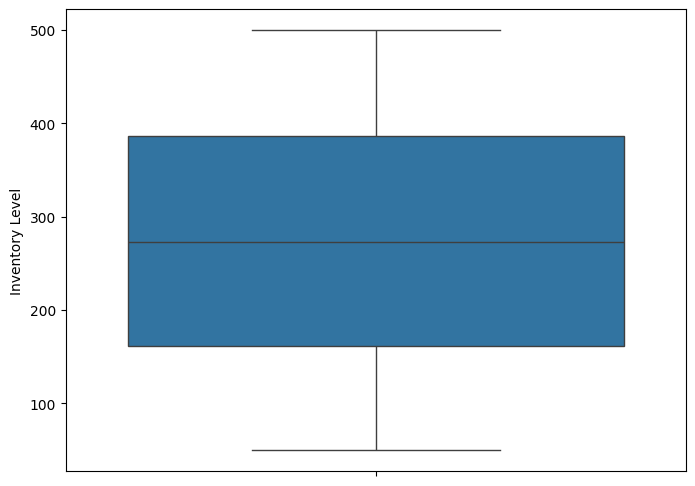

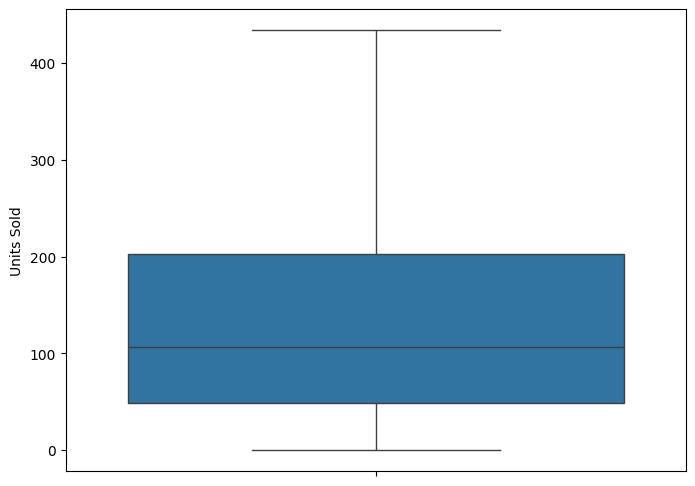

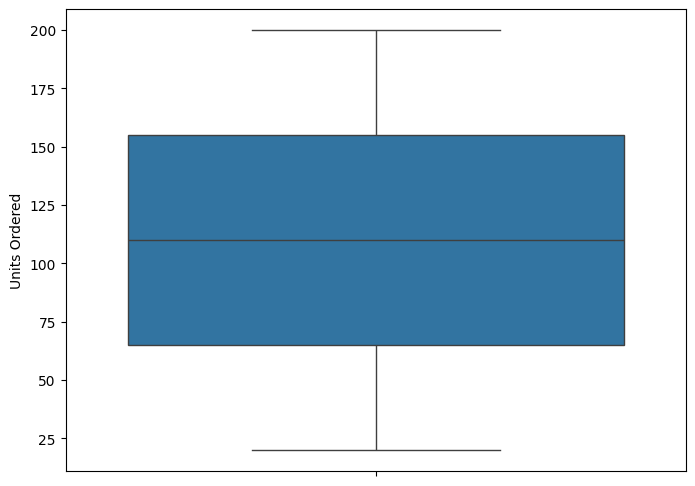

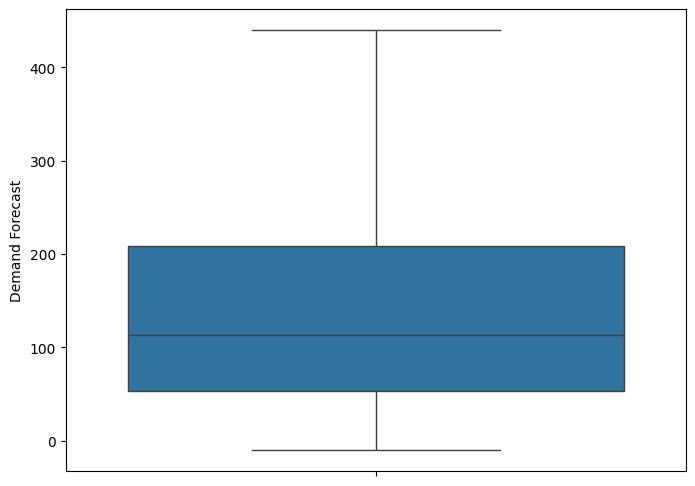

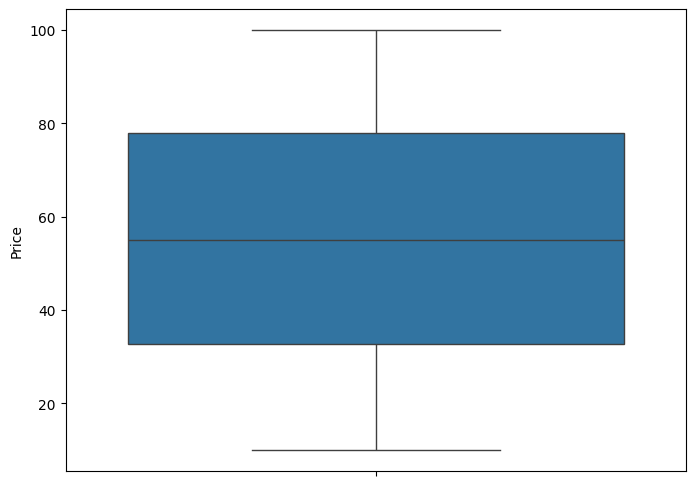

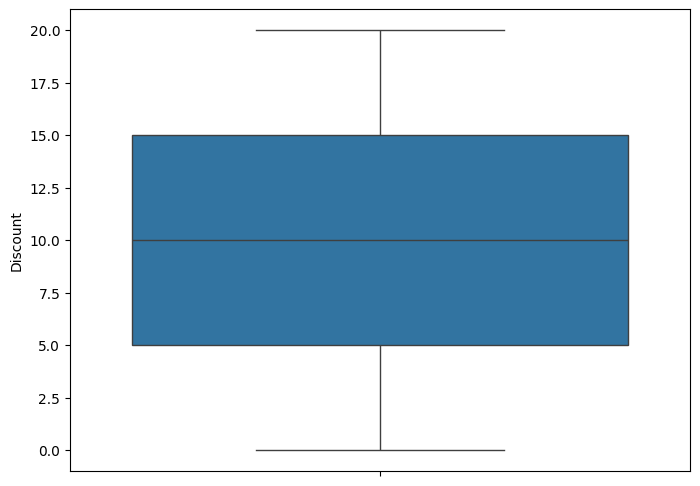

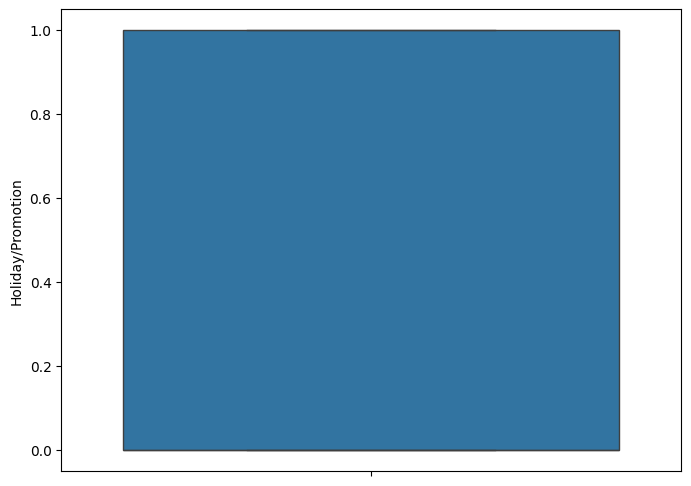

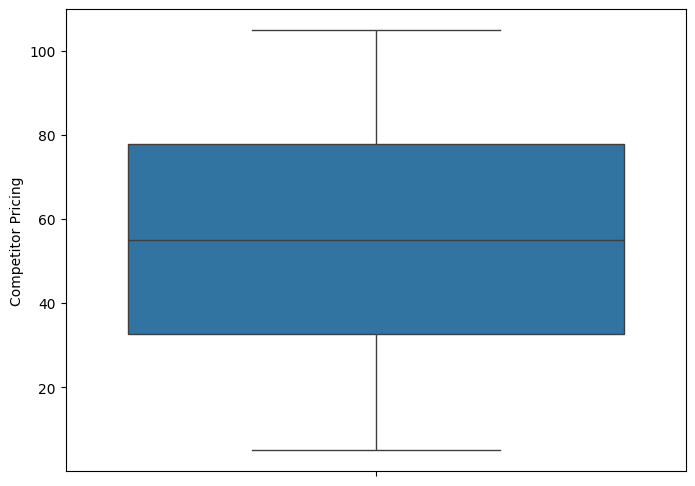

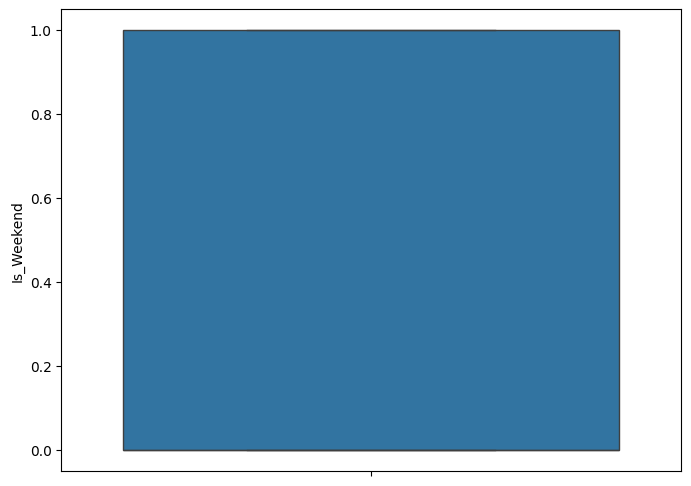

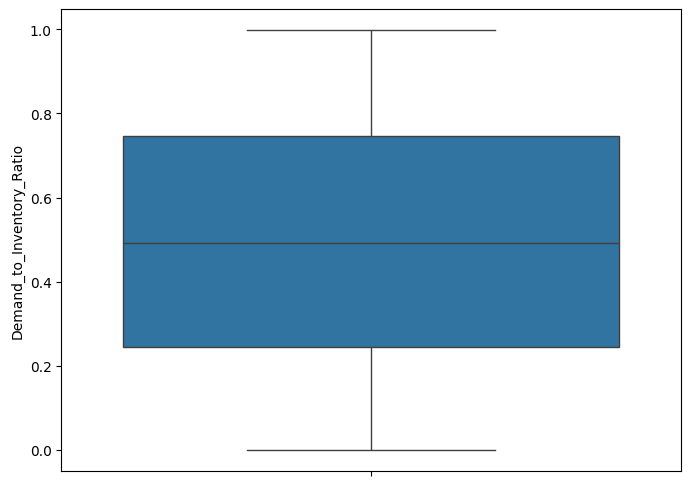

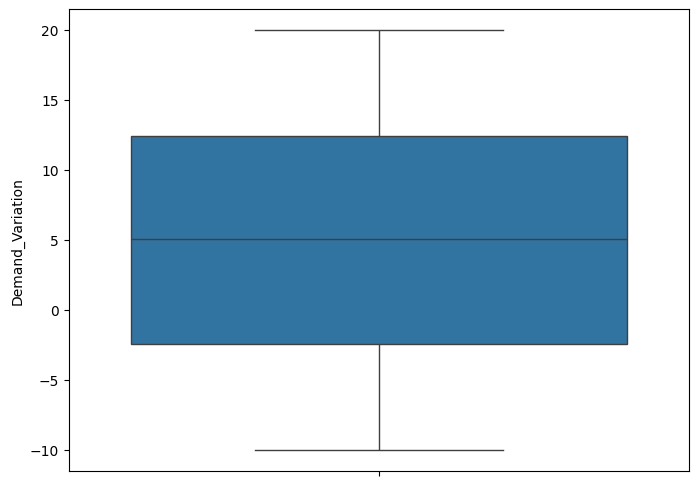

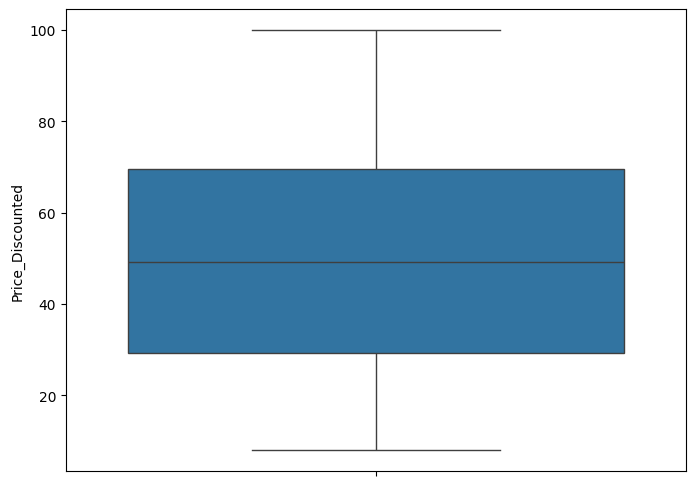

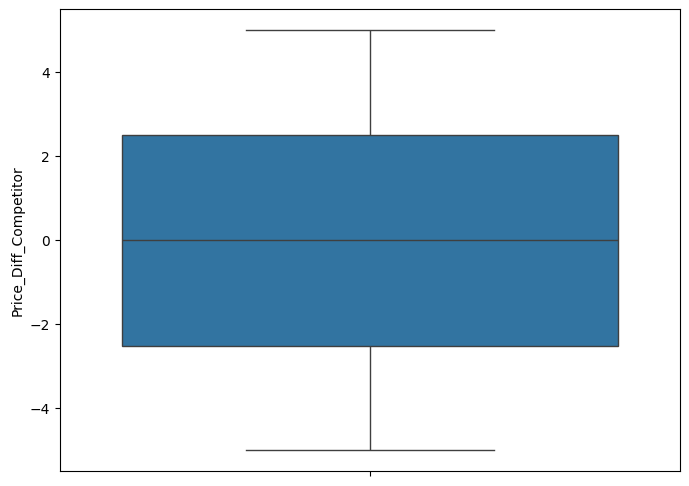

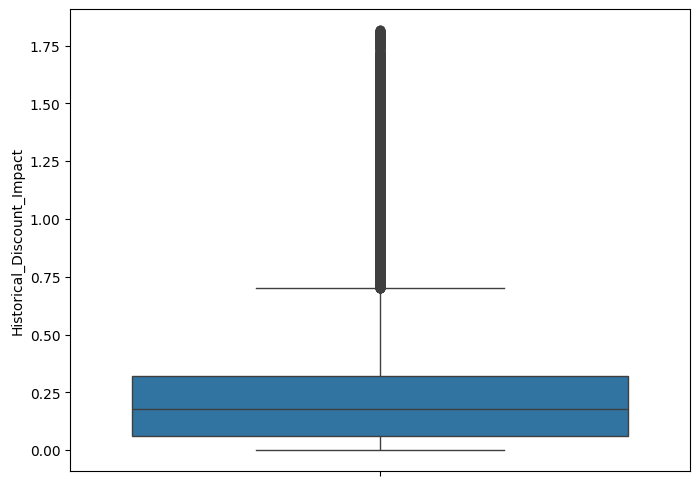

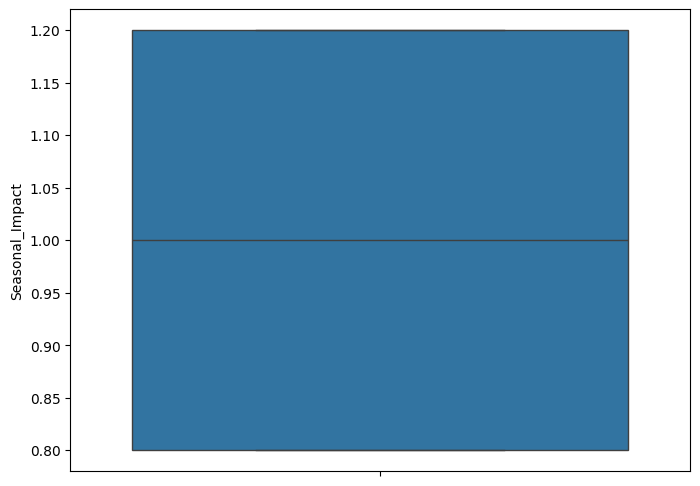

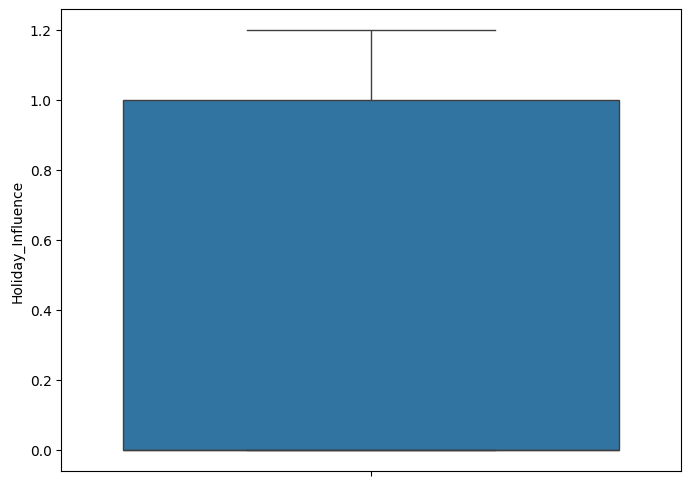

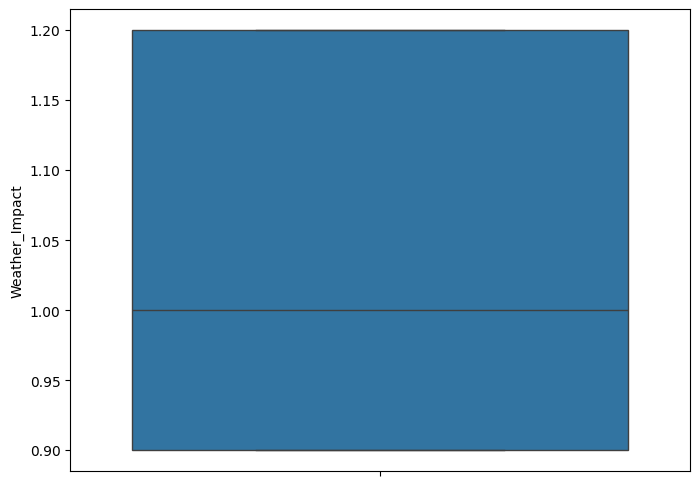

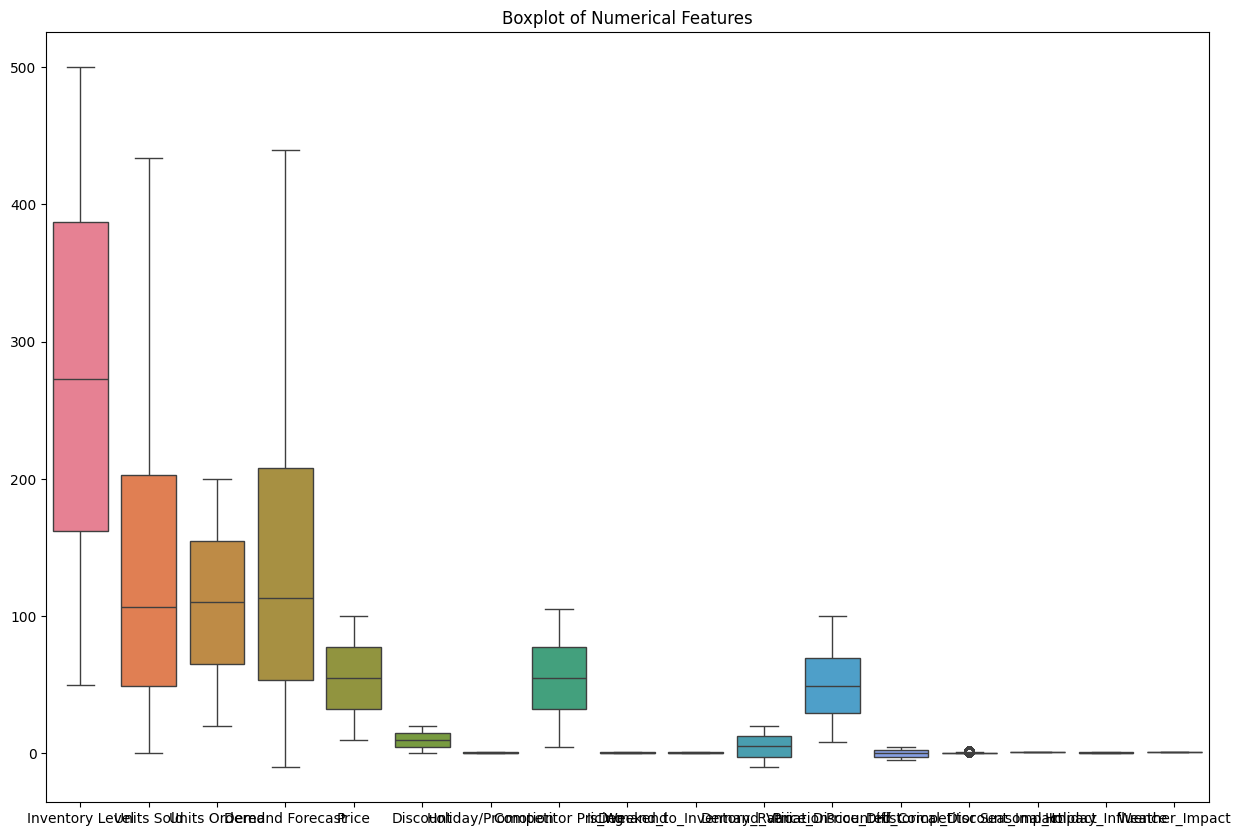

In [ ]:
for column in df_capped_2.select_dtypes(include=['int64','float64']).columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(df_capped_2[column])
    plt.show()

plt.figure(figsize=(15, 10))
sns.boxplot(data=df_capped_2.select_dtypes(include=['int64','float64']))
plt.title('Boxplot of Numerical Features')
plt.show()

        Date Store ID Product ID     Category Region  Inventory Level  \
0 2022-01-01     S001      P0001    Groceries  North              231   
1 2022-01-01     S001      P0002         Toys  South              204   
2 2022-01-01     S001      P0003         Toys   West              102   
3 2022-01-01     S001      P0004         Toys  North              469   
4 2022-01-01     S001      P0005  Electronics   East              166   

   Units Sold  Units Ordered  Demand Forecast  Price  ...  Weekday Is_Weekend  \
0         127             55           135.47  33.50  ...        5          1   
1         150             66           144.04  63.01  ...        5          1   
2          65             51            74.02  27.99  ...        5          1   
3          61            164            62.18  32.72  ...        5          1   
4          14            135             9.26  73.64  ...        5          1   

   Demand_to_Inventory_Ratio  Demand_Variation Price_Discounted  \
0      

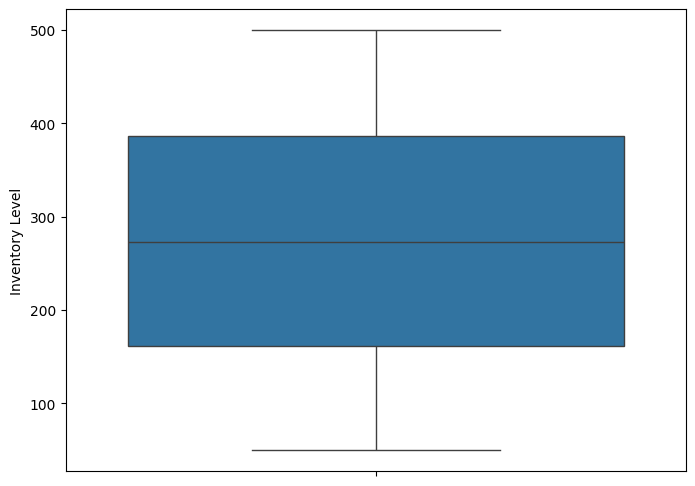

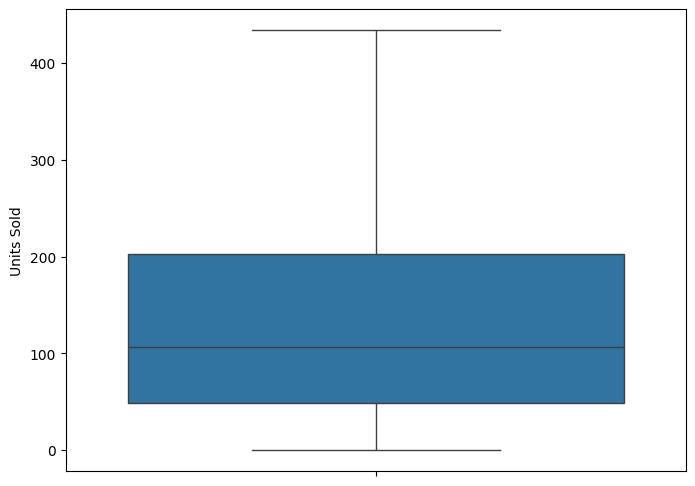

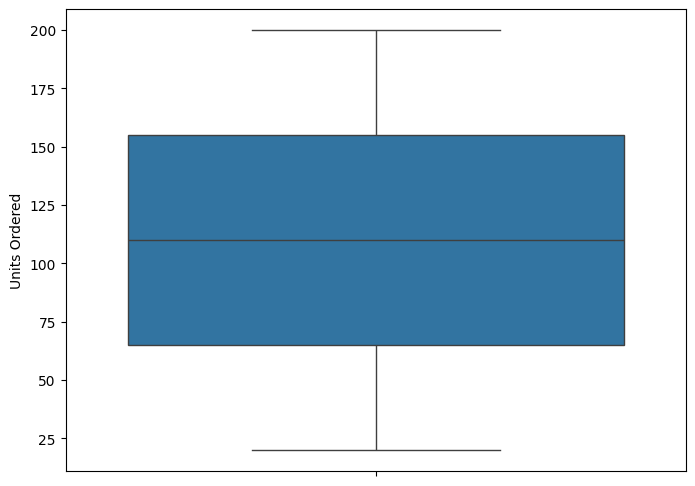

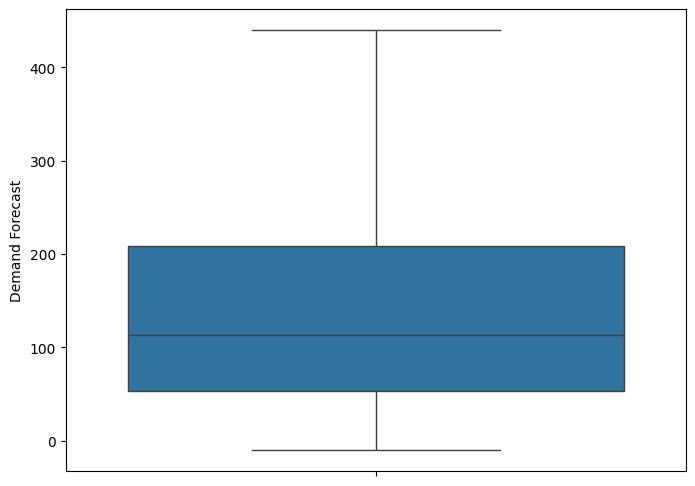

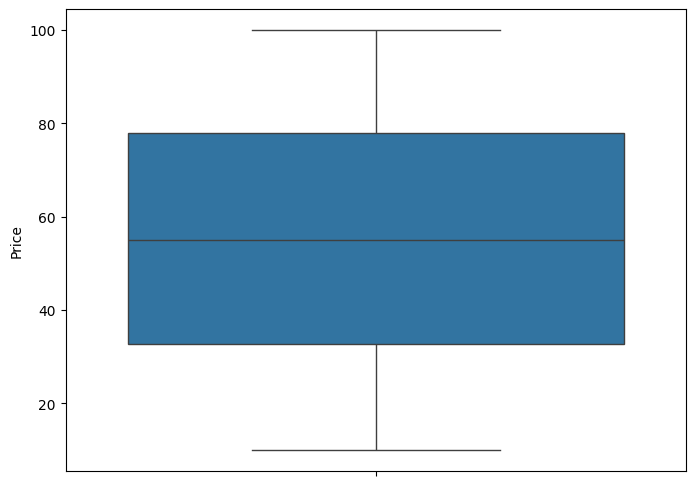

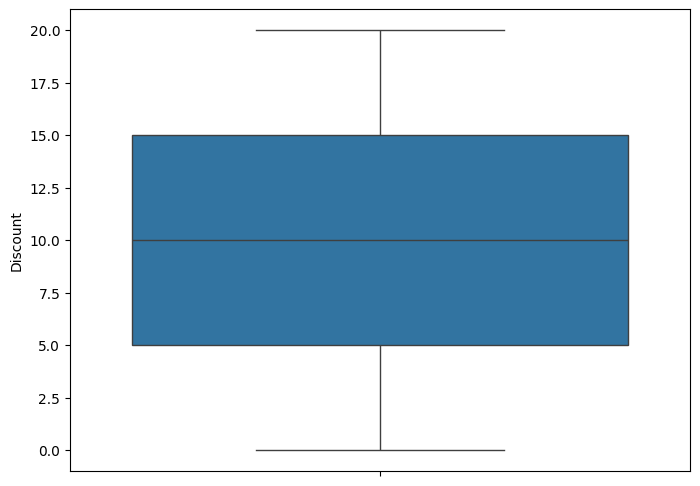

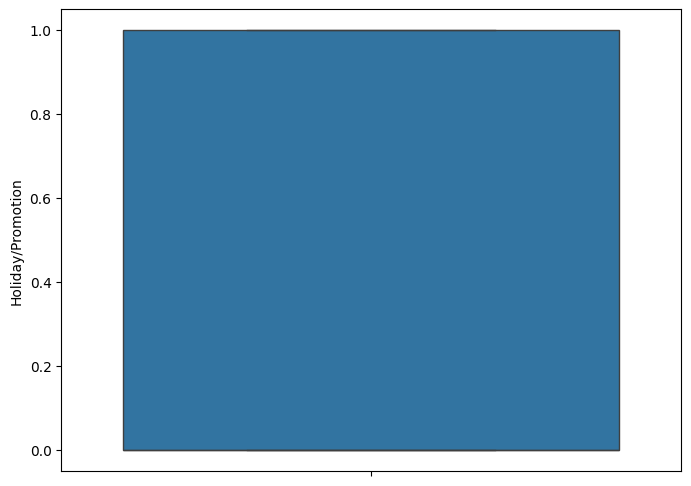

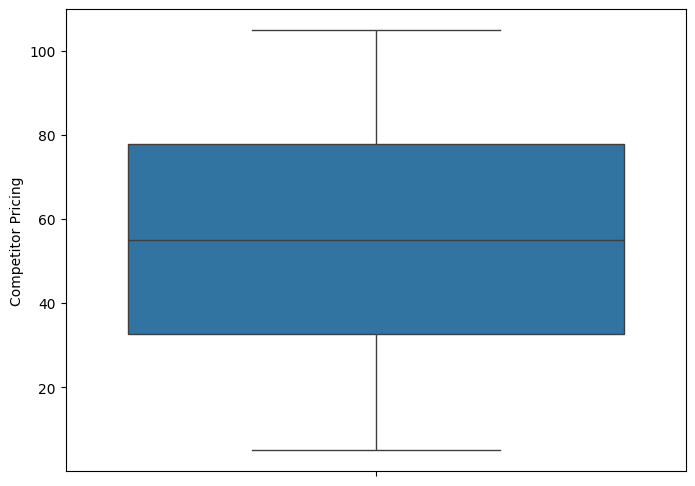

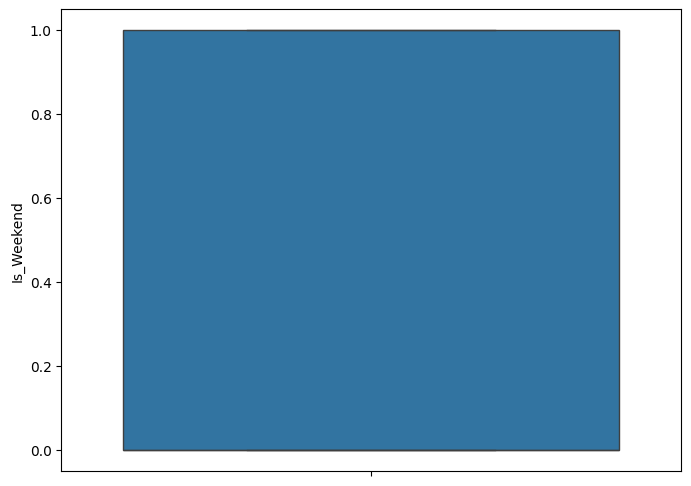

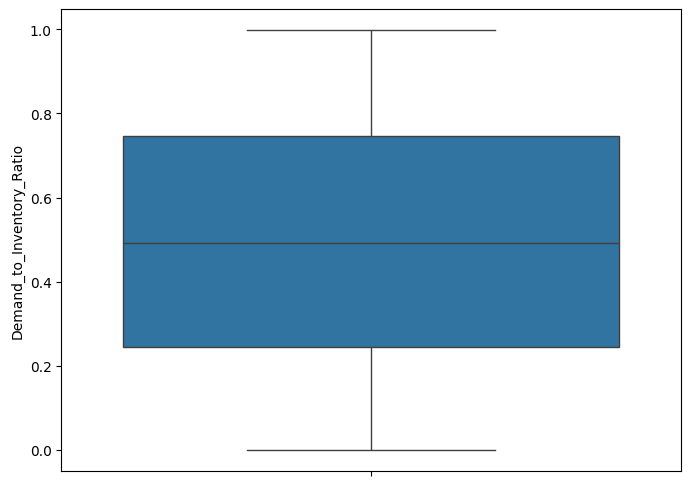

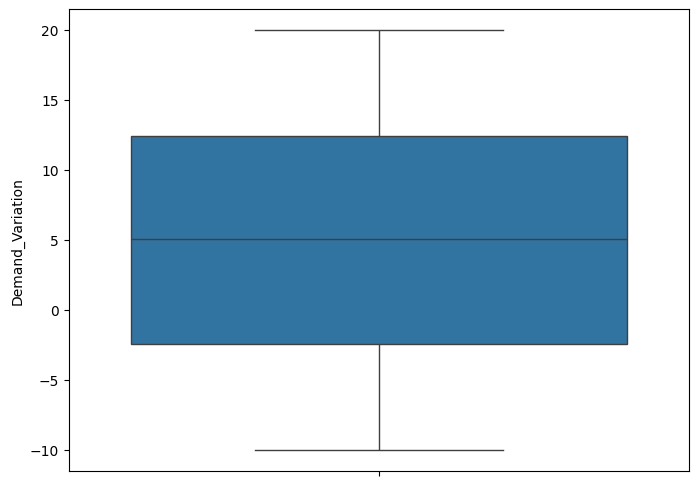

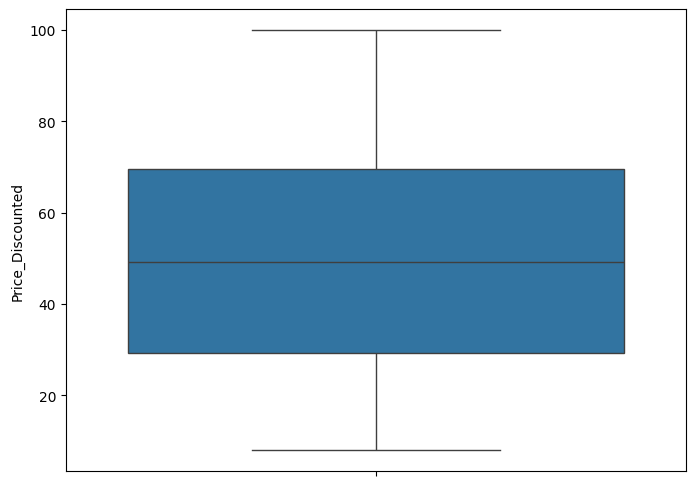

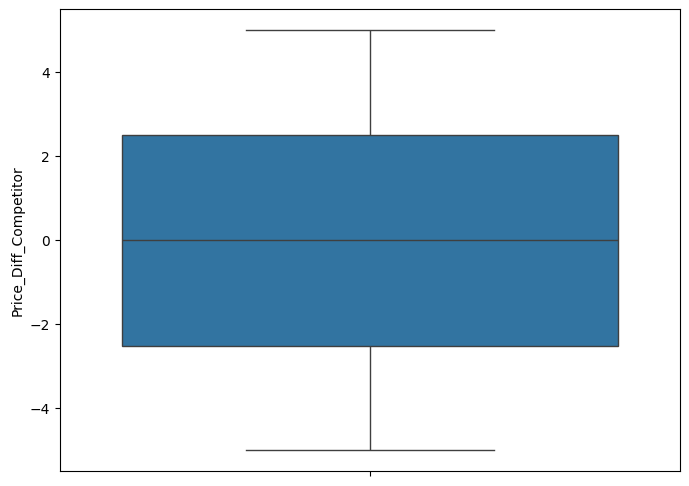

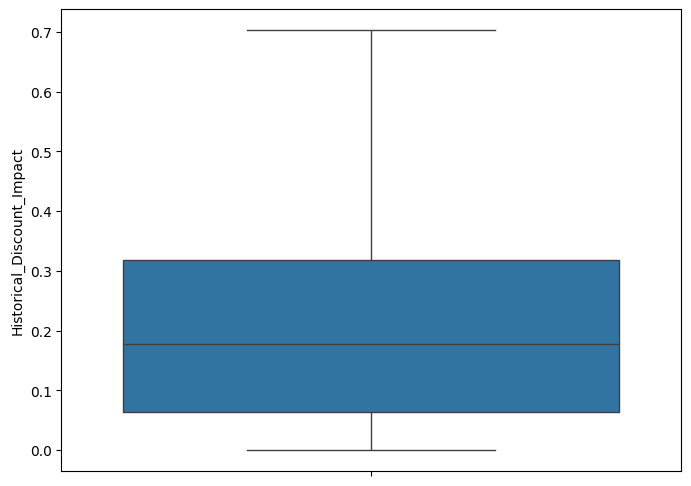

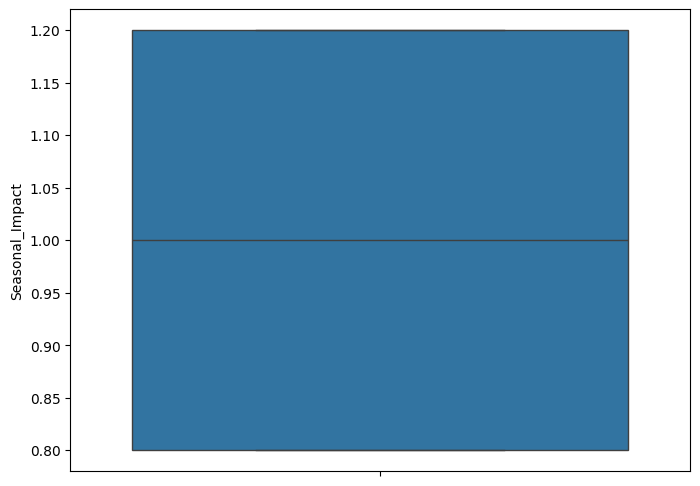

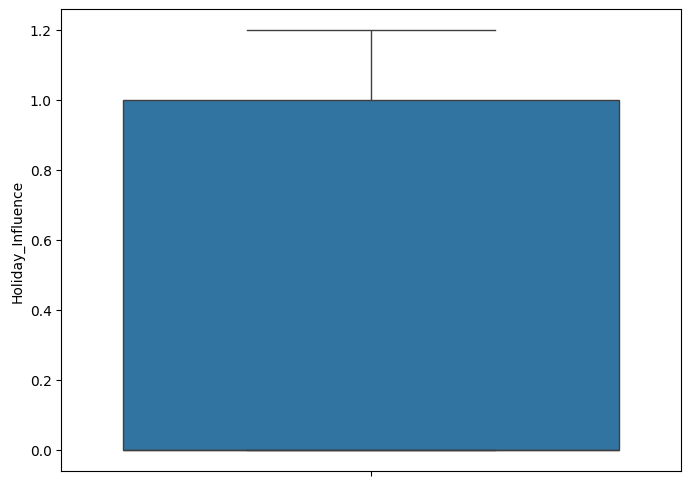

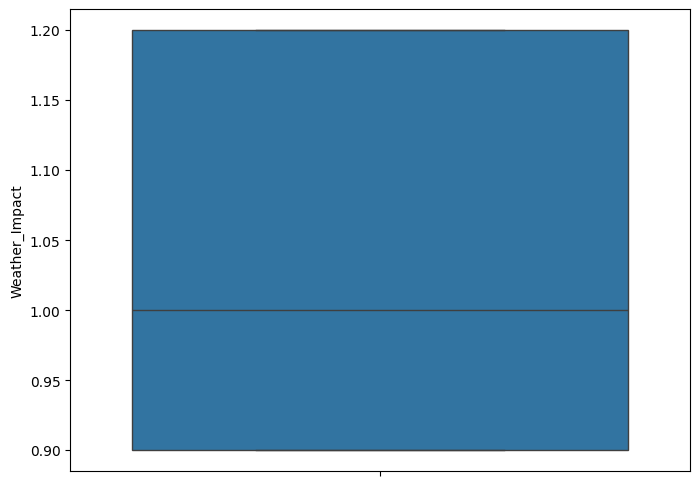

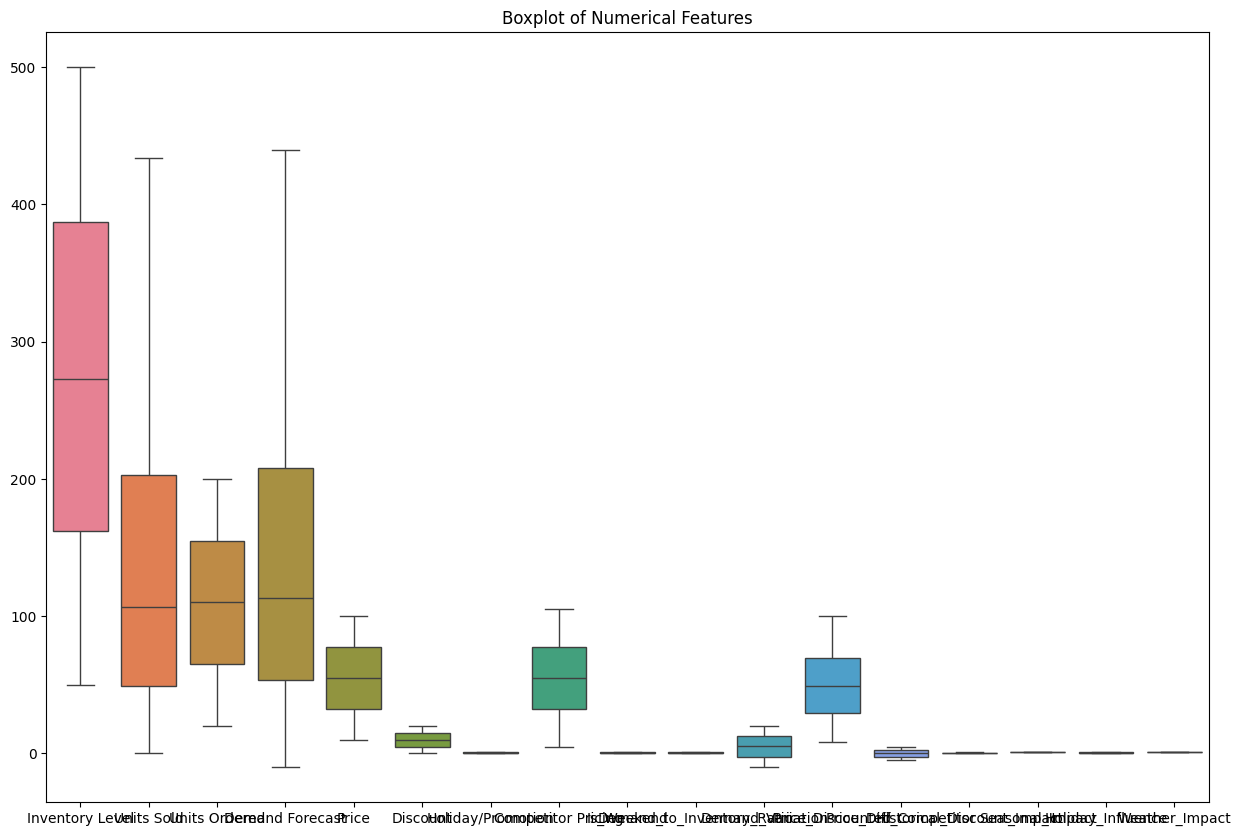

In [ ]:
# Function to cap outliers using IQR (Interquartile Range)
def cap_outliers(df, columns):
    for col in columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define the lower and upper bounds for acceptable values
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Cap values outside the bounds to the lower or upper threshold
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

    return df

# List of columns from which to cap outliers
columns_to_cap_outliers = ["Historical_Discount_Impact"]

# Assuming df_rename is your original DataFrame, apply the cap_outliers function
df_capped_2 = cap_outliers(df_capped_2, columns_to_cap_outliers)

# Display the first few rows of the capped DataFrame
print(df_capped_2.head())

# Generate individual boxplots for each column after capping outliers
for column in df_capped_2.select_dtypes(include=['int64','float64']).columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(df_capped_2[column])
    plt.show()

# Generate a combined boxplot for all selected columns after capping outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_capped_2.select_dtypes(include=['int64','float64']))
plt.title('Boxplot of Numerical Features')
plt.show()


## 3. Scaling the numerical values

In [ ]:
def apply_min_max_scaler(df, columns_to_scale):
    # """
    # Scales specified columns of a DataFrame using Min-Max Scaling.

    # Parameters:
    #     df (pd.DataFrame): The input DataFrame to scale.
    #     columns_to_scale (list): List of column names to apply Min-Max scaling.

    # Returns:
    #     pd.DataFrame: The DataFrame with scaled columns.
    # """
    from sklearn.preprocessing import MinMaxScaler
    import pandas as pd

    # Create a copy of the input DataFrame to preserve the original
    df_scaled = df.copy()

    # Initialize the scaler
    scaler = MinMaxScaler()

    # Apply scaling to each specified column
    for column in df.select_dtypes(include=['int64','float64']).columns:
        if column in df.columns:
          # Replace infinite values with NaN
            df_scaled[column] = df_scaled[column].replace([np.inf, -np.inf], np.nan)

            # Fill NaN values with the column's median
            df_scaled[column] = df_scaled[column].fillna(df_scaled[column].median())
            # Clip values to a reasonable range before scaling
            # For example, between the 1st and 99th percentiles
            lower_bound = df_scaled[column].quantile(0.01)
            upper_bound = df_scaled[column].quantile(0.99)
            df_scaled[column] = df_scaled[column].clip(lower=lower_bound, upper=upper_bound)

            df_scaled[column] = scaler.fit_transform(df_scaled[[column]]) # Changed this line: scaling the clipped and filled df_scaled
    return df_scaled

columns_to_scale = [df_capped_2.select_dtypes(include=['int64','float64']).columns]
df_scaled = apply_min_max_scaler(df_capped_2, columns_to_scale)

df_scaled

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,...,Weekday,Is_Weekend,Demand_to_Inventory_Ratio,Demand_Variation,Price_Discounted,Price_Diff_Competitor,Historical_Discount_Impact,Seasonal_Impact,Holiday_Influence,Weather_Impact
0,2022-01-01,S001,P0001,Groceries,North,0.399093,0.290993,0.191011,0.307660,0.256291,...,5,1.0,0.552155,0.618027,0.200024,0.889683,0.824810,0.5,0.000000,0.000000
1,2022-01-01,S001,P0002,Toys,South,0.337868,0.344111,0.252809,0.327168,0.590796,...,5,1.0,0.740627,0.127211,0.475328,0.178754,0.444555,0.5,0.000000,1.000000
2,2022-01-01,S001,P0003,Toys,West,0.106576,0.147806,0.168539,0.167784,0.193834,...,5,1.0,0.637706,0.636735,0.181260,0.160368,0.490789,1.0,1.000000,1.000000
3,2022-01-01,S001,P0004,Toys,North,0.938776,0.138568,0.803371,0.140833,0.247450,...,5,1.0,0.125060,0.370068,0.230903,0.294178,0.421945,0.5,0.833333,0.333333
4,2022-01-01,S001,P0005,Electronics,East,0.251701,0.030023,0.640449,0.020373,0.711290,...,5,1.0,0.078063,0.168707,0.746247,0.979571,0.000000,1.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73095,2024-01-01,S005,P0016,Furniture,East,0.092971,0.016166,0.595506,0.041314,0.712310,...,0,0.0,0.076674,0.685714,0.575336,0.631256,0.380783,0.0,0.000000,0.333333
73096,2024-01-01,S005,P0017,Toys,North,0.585034,0.115473,0.449438,0.109534,0.812514,...,0,0.0,0.158433,0.242517,0.754095,0.376915,0.170252,0.5,0.000000,0.333333
73097,2024-01-01,S005,P0018,Clothing,West,0.505669,0.080831,0.730337,0.089548,0.002494,...,0,0.0,0.124288,0.454082,0.004100,0.520940,1.000000,0.0,0.000000,0.000000
73098,2024-01-01,S005,P0019,Toys,East,0.723356,0.607390,0.000000,0.615070,0.478916,...,0,0.0,0.712291,0.551701,0.383249,0.228805,0.525599,0.5,0.000000,0.000000


## 4. Label Encoding the categorical values

In [ ]:
def Lebel_Encoding(df):
    from sklearn.preprocessing import LabelEncoder
    df_Encoded = df.copy()
    for column in df.select_dtypes(include=['object','category']).columns:


            encoder = LabelEncoder()
            df_Encoded[column] = encoder.fit_transform(df[column])
    return df_Encoded

df_encoded = Lebel_Encoding(df_scaled)
df_encoded

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,...,Weekday,Is_Weekend,Demand_to_Inventory_Ratio,Demand_Variation,Price_Discounted,Price_Diff_Competitor,Historical_Discount_Impact,Seasonal_Impact,Holiday_Influence,Weather_Impact
0,2022-01-01,0,0,3,1,0.399093,0.290993,0.191011,0.307660,0.256291,...,5,1.0,0.552155,0.618027,0.200024,0.889683,0.824810,0.5,0.000000,0.000000
1,2022-01-01,0,1,4,2,0.337868,0.344111,0.252809,0.327168,0.590796,...,5,1.0,0.740627,0.127211,0.475328,0.178754,0.444555,0.5,0.000000,1.000000
2,2022-01-01,0,2,4,3,0.106576,0.147806,0.168539,0.167784,0.193834,...,5,1.0,0.637706,0.636735,0.181260,0.160368,0.490789,1.0,1.000000,1.000000
3,2022-01-01,0,3,4,1,0.938776,0.138568,0.803371,0.140833,0.247450,...,5,1.0,0.125060,0.370068,0.230903,0.294178,0.421945,0.5,0.833333,0.333333
4,2022-01-01,0,4,1,0,0.251701,0.030023,0.640449,0.020373,0.711290,...,5,1.0,0.078063,0.168707,0.746247,0.979571,0.000000,1.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73095,2024-01-01,4,15,2,0,0.092971,0.016166,0.595506,0.041314,0.712310,...,0,0.0,0.076674,0.685714,0.575336,0.631256,0.380783,0.0,0.000000,0.333333
73096,2024-01-01,4,16,4,1,0.585034,0.115473,0.449438,0.109534,0.812514,...,0,0.0,0.158433,0.242517,0.754095,0.376915,0.170252,0.5,0.000000,0.333333
73097,2024-01-01,4,17,0,3,0.505669,0.080831,0.730337,0.089548,0.002494,...,0,0.0,0.124288,0.454082,0.004100,0.520940,1.000000,0.0,0.000000,0.000000
73098,2024-01-01,4,18,4,0,0.723356,0.607390,0.000000,0.615070,0.478916,...,0,0.0,0.712291,0.551701,0.383249,0.228805,0.525599,0.5,0.000000,0.000000


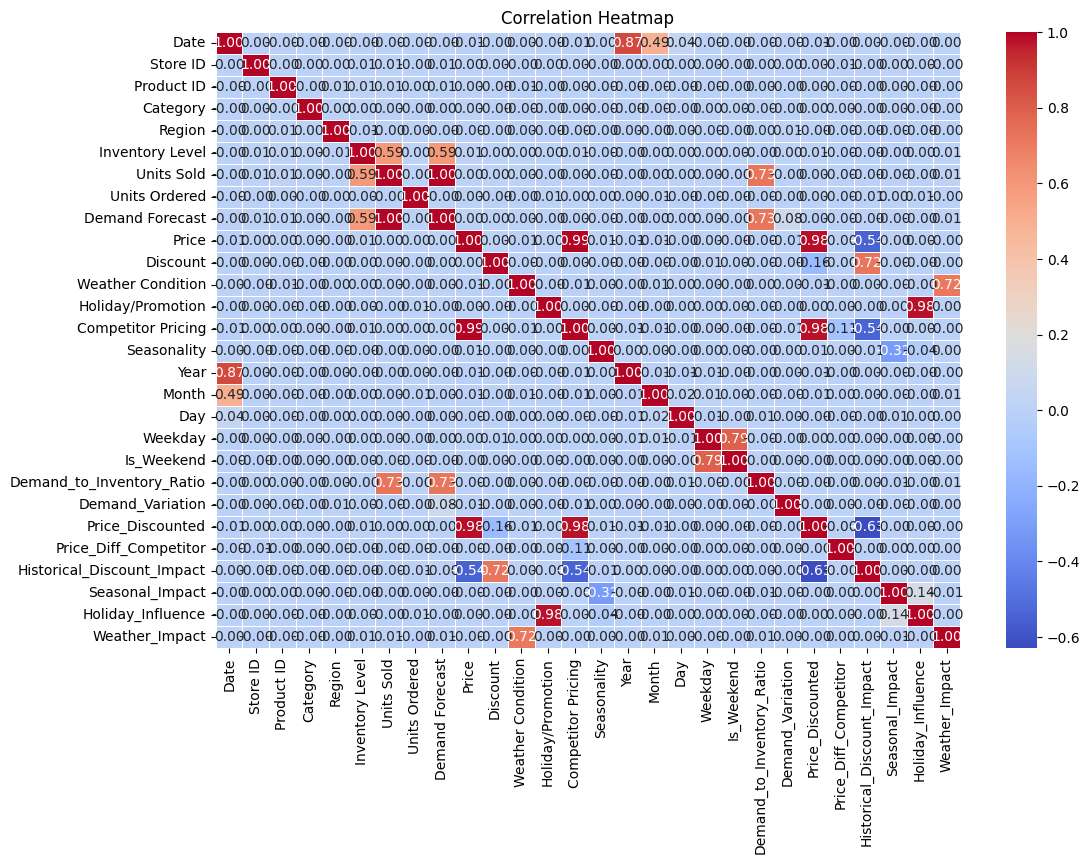

In [ ]:
#Calculate the correlation matrix for numerical features
corr_matrix = df_encoded.corr()

# Step 4: Generate a heatmap to visualize feature relationships
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## 5. Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def train_test_splitting(df, target_column):
    df = df.sort_values(by="Date")  # Ensure data is sorted by time

    # Separate features (X) and target (y)
    X = df.drop(columns=[target_column, "Date"])  # Drop target and Date
    y = df[target_column]

    # Split dataset (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    return X_train, X_test, y_train, y_test

## 6. Model Train

*   Linear Regression
*   Decision Tree
*   Random Forest
*   Gradient Boosting
*   XGBoost
*   LightGBM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(y_test, y_pred, model_name):
    """Evaluates and prints model performance metrics."""
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Model: {model_name}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    results_df = pd.DataFrame({"Actual": y_test.values, "Predicted": y_pred})
    print("\n First 10 Actual vs Predicted Values:")
    print(results_df.head(10))

def train_model(X_train, X_test, y_train, y_test, model_name):
    """Trains the specified model and evaluates its performance."""

    if model_name == "Linear Regression":
        print("\n Training Linear Regression Model...")
        model = LinearRegression()

    elif model_name == "Decision Tree":
        print("\n Training Decision Tree Model...")
        model = DecisionTreeRegressor(max_depth=10, random_state=42)

    elif model_name == "Random Forest":
        print("\n Training Random Forest Model...")
        model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)

    elif model_name == "Gradient Boosting":
        print("\n Training Gradient Boosting Model...")
        model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)

    elif model_name == "XGBoost":
        print("\n Training XGBoost Model...")
        model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)

    elif model_name == "LightGBM":
        print("\n Training LightGBM Model...")
        model = LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)

    else:
        print(f" Error: {model_name} is not a valid model name.")
        return None, None

    # Train and predict for selected model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    evaluate_model(y_test, y_pred, model_name)
    return model, y_pred


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_splitting(df_encoded, target_column="Price")
# Choose model and train
lr_model, arima_pred = train_model(X_train, X_test, y_train, y_test, model_name="Linear Regression")
gd_model, gd_pred = train_model(X_train, X_test, y_train, y_test, model_name="Gradient Boosting")
dt_model, dt_pred = train_model(X_train, X_test, y_train, y_test, model_name="Decision Tree")
rf_model, rf_pred = train_model(X_train, X_test, y_train, y_test, model_name="Random Forest")
xgb_model, xgb_pred = train_model(X_train, X_test, y_train, y_test, model_name="XGBoost")
lgbm_model, lgbm_pred = train_model(X_train, X_test, y_train, y_test, model_name="LightGBM")



 Training Linear Regression Model...

 Model: Linear Regression
Mean Absolute Error (MAE): 0.0008
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0026
R² Score: 0.9999

 First 10 Actual vs Predicted Values:
     Actual  Predicted
0  0.660735   0.660624
1  0.758558   0.758446
2  0.083881   0.084173
3  0.809907   0.809952
4  0.879846   0.880153
5  0.116867   0.116905
6  0.551462   0.551217
7  0.471208   0.470834
8  0.164362   0.163501
9  0.493539   0.494081

 Training Gradient Boosting Model...

 Model: Gradient Boosting
Mean Absolute Error (MAE): 0.0010
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0014
R² Score: 1.0000

 First 10 Actual vs Predicted Values:
     Actual  Predicted
0  0.660735   0.661056
1  0.758558   0.758723
2  0.083881   0.084090
3  0.809907   0.809841
4  0.879846   0.878883
5  0.116867   0.117879
6  0.551462   0.550774
7  0.471208   0.469690
8  0.164362   0.163592
9  0.493539   0.492239

 Training Decision Tree Model...

 Mode

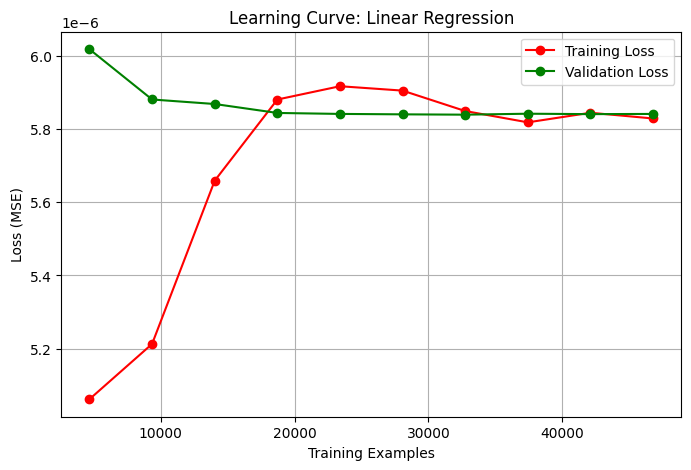

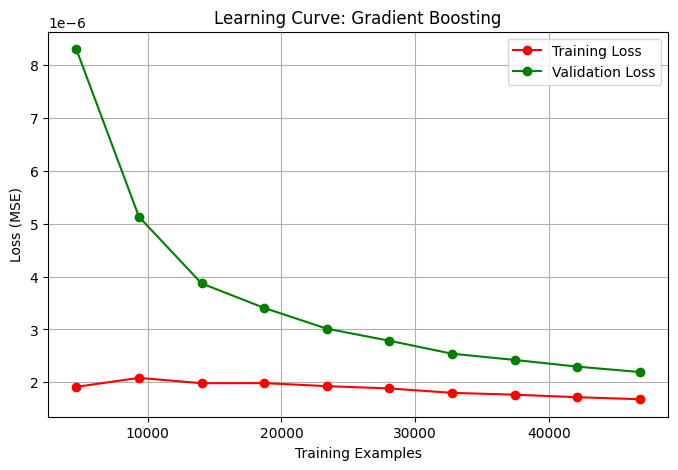

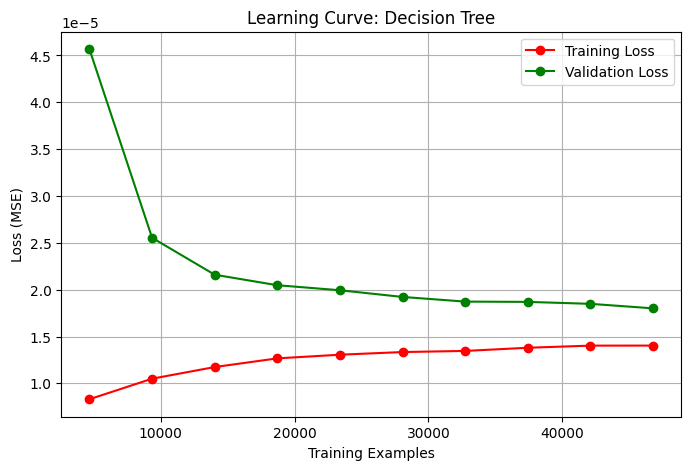

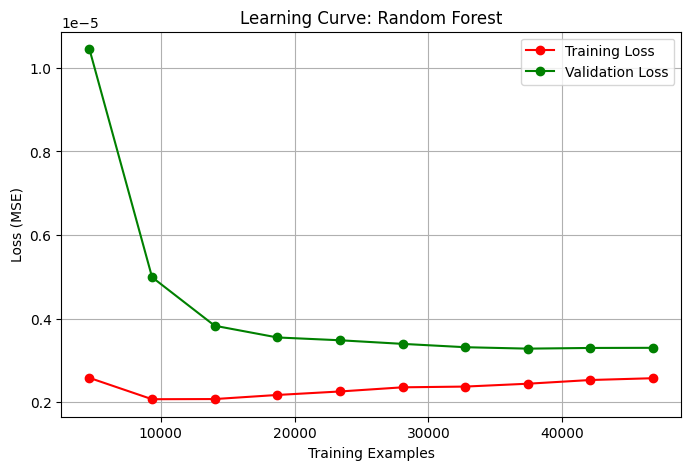

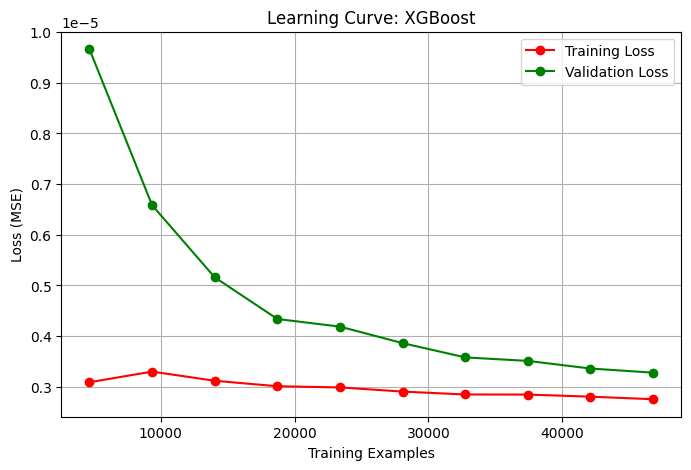

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2568
[LightGBM] [Info] Number of data points in the train set: 4678, number of used features: 25
[LightGBM] [Info] Start training from score 0.504332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

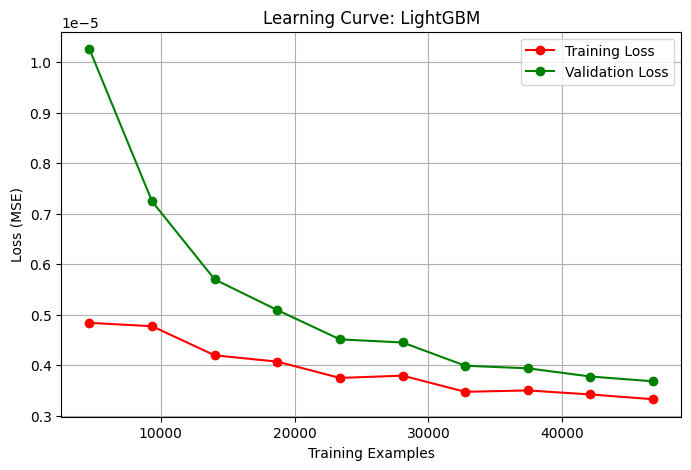

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X_train, y_train, model_name):
    """Generates and plots the learning curve (loss curve) for a given model."""
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring="neg_mean_squared_error", train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training Loss")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Validation Loss")
    plt.xlabel("Training Examples")
    plt.ylabel("Loss (MSE)")
    plt.title(f"Learning Curve: {model_name}")
    plt.legend()
    plt.grid()
    plt.show()


plot_learning_curve(lr_model, X_train, y_train, "Linear Regression")
plot_learning_curve(gd_model, X_train, y_train, "Gradient Boosting")
plot_learning_curve(dt_model, X_train, y_train, "Decision Tree")
plot_learning_curve(rf_model, X_train, y_train, "Random Forest")
plot_learning_curve(xgb_model, X_train, y_train, "XGBoost")
plot_learning_curve(lgbm_model, X_train, y_train, "LightGBM")

## **Optimum Price Recommendations**

In [ ]:
def recommend_price(input_data, features=X_train.columns): # Set features as a parameter with a default value
    """
    Generate a recommended price based on the trained model.
    """
    predicted_price = gd_model.predict(input_data[features])
    recommended_price = np.where(input_data["Demand_to_Inventory_Ratio"] > 1,
                                 predicted_price * 1.1,  # Increase price if demand is high
                                 predicted_price * 0.9)  # Decrease price if demand is low
    return recommended_price

# Generate and display recommendations
sample_data = X_test.copy()
# Adding the 'Price' column back to sample_data from y_test
sample_data["Price"] = y_test.values
sample_data["Recommended_Price"] = recommend_price(sample_data) # No need to pass features here if using the default
print("\nPrice Recommendations:")
print(sample_data[["Price", "Recommended_Price"]].head(30)*100) # Changed 'Pricing' to 'Price'


Price Recommendations:
            Price  Recommended_Price
58444   66.073453          59.495077
58443   75.855815          68.285114
58442    8.388121           7.568069
58441   80.990705          72.885735
58440   87.984584          79.099444
58439   11.686692          10.609129
58438   55.146225          49.569675
58437   47.120834          42.272118
58424   16.436182          14.723253
58435   49.353888          44.301523
58434   43.890274          39.840435
58433   82.067558          74.059979
58432   37.701202          34.009469
58431   62.242122          55.937344
58430   33.745182          30.309373
58429   77.476763          69.906529
58428   96.463387          86.612605
58427   22.670596          20.463864
58426    1.927001           1.695026
58436   30.049875          27.116345
58565   24.257538          21.820522
58566   38.744049          34.776958
58567   45.658581          41.014115
58572    4.840172           4.314461
58569   32.997053          29.686248
58570  100.000

In [ ]:
sample_data

,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Discount,Weather Condition,...,Demand_to_Inventory_Ratio,Demand_Variation,Price_Discounted,Price_Diff_Competitor,Historical_Discount_Impact,Seasonal_Impact,Holiday_Influence,Weather_Impact,Price,Recommended_Price
58444,2,4,1,3,0.260771,0.228637,0.904494,0.239531,0.00,2,...,0.590384,0.518367,0.694236,0.852911,0.000000,0.5,0.833333,0.333333,0.660735,0.594951
58443,2,3,1,2,0.793651,0.706697,0.679775,0.684450,0.75,1,...,0.765631,0.125850,0.658768,0.745659,0.270803,1.0,1.000000,0.000000,0.758558,0.682851
58442,2,2,3,3,0.600907,0.448037,0.022472,0.434744,1.00,2,...,0.613580,0.204082,0.058127,0.329928,1.000000,0.0,0.666667,0.333333,0.083881,0.075681
58441,2,1,1,2,0.410431,0.364896,0.780899,0.341508,0.25,3,...,0.678427,0.035374,0.799691,0.837589,0.085361,0.0,0.666667,1.000000,0.809907,0.728857
58440,2,0,1,3,0.503401,0.323326,0.168539,0.321181,0.50,0,...,0.511024,0.343878,0.816437,0.509704,0.158954,0.0,0.666667,0.333333,0.879846,0.790994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73027,1,7,2,1,0.369615,0.096998,0.691011,0.116568,0.50,3,...,0.193129,0.619728,0.836063,0.041879,0.155701,0.5,0.000000,1.000000,0.901043,0.814339
73026,1,6,4,3,0.000000,0.002309,0.106742,0.000000,1.00,2,...,0.030207,0.055102,0.481392,0.632278,0.440086,0.5,0.833333,0.333333,0.598164,0.538564
73025,1,5,4,0,0.238095,0.364896,0.320225,0.344103,1.00,1,...,1.000000,0.074150,0.065311,0.854954,1.000000,0.5,0.833333,0.000000,0.092609,0.083263
73035,1,15,4,1,0.460317,0.251732,0.988764,0.244243,0.25,0,...,0.426670,0.248639,0.345034,0.126660,0.168179,0.5,0.000000,0.333333,0.344706,0.310671


## 8. X-AI

*   SHAP
*   LIME

In [ ]:
import lime
import lime.lime_tabular
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import shap

import xgboost as xgb
from lime import lime_tabular

In [ ]:
shap.initjs()
# Create the SHAP explainer and calculate SHAP values
explainer_gd = shap.TreeExplainer(gd_model)
shap_values_gd = explainer_gd.shap_values(X_train)

# Visualize the first prediction's explanation
shap.force_plot(explainer_gd.expected_value, shap_values_gd[0,:], X_train.iloc[0,:])

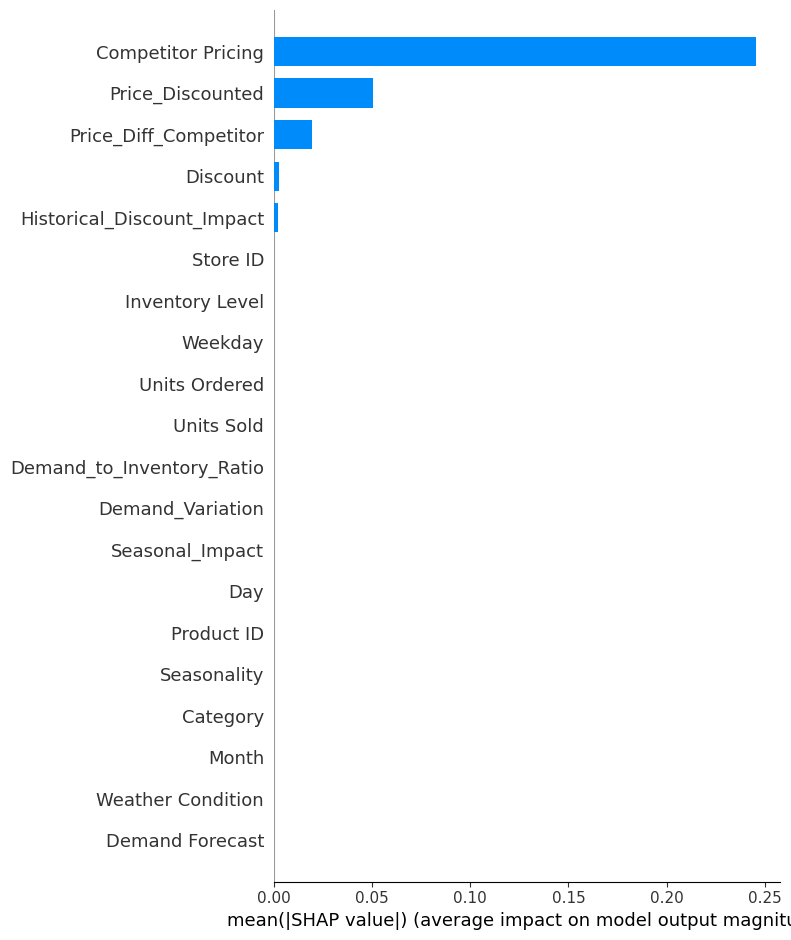

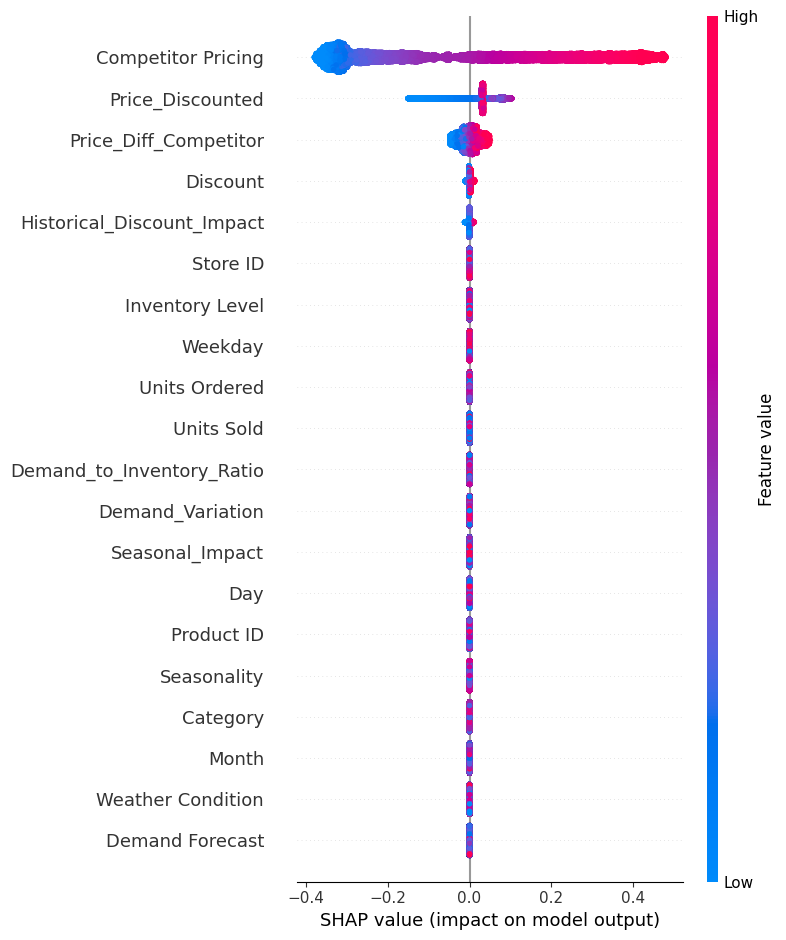

In [ ]:
# Create the SHAP explainer
explainer = shap.TreeExplainer(gd_model)
shap_values = explainer.shap_values(X_train)

# Generate SHAP summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

# You can also create a detailed SHAP summary plot (beeswarm plot) to see the distribution
shap.summary_plot(shap_values, X_train, plot_type='dot')

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    mode='regression'
)

# Choose a test sample to explain (Index 10 as an example)
sample_index = 10
exp = explainer.explain_instance(X_test.iloc[sample_index].values, gd_model.predict, num_features=5)

# Display the LIME Table Plot
exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
